In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns

In [302]:
df_spb = pd.read_csv('final_spb', sep=',') # вытаскиваем таблицы
df_moscow = pd.read_csv('final_moscow', sep=',')

In [303]:
df_spb.drop(columns='Дата', inplace=True) # конкретные даты нам уже не понадобятся
df_moscow.drop(columns='Дата', inplace=True)

### 1. Параметрический тест: равенство матожиданий

Проверим равенство матожиданий дневной температуры при помощи z-теста (гипотеза двусторонняя). Сделаем это тремя разными способами: 
1. внутри времен года;
2. внутри времен года, убрав выбросы внутри каждого;
3. внутри времен, убрав выбросы предварительно во всей выборке.

Для второго и третьего сценария построим график в зависимости от того, как много выбросов "срезаем" выборами уровня квантиля. 

Стоит сказать, что непрерывные данные о погоде нельзя считать независимыми. Для этого стоит рассматривать большие выборки за несколько десятков лет; поскольку нам доступно всего пять лет, могут появляться достаточно странные результаты. Чтобы усилить предпосылки тестов (независимость, нормальность) и действие ЦПТ на рассматриваемых выборках, полезно удалять выбросы. 

In [387]:
# словарь для более простого обращения к временам года
seasons = {'winter':[12, 1, 2], 'spring':[3, 4, 5], 'summer':[6, 7, 8], 'autumn':[9, 10, 11]}

# цикл для каждого времени года 
for season in seasons:
    a = df_spb.loc[df_spb['Месяц'].isin(seasons[season]), 'Дневная температура'].to_numpy()
    b = df_moscow.loc[df_moscow['Месяц'].isin(seasons[season]), 'Дневная температура'].to_numpy()

    diff = a.mean() - b.mean() # разница выборочных средних
    var = ((a.std() ** 2) / len(a)) + ((b.std() ** 2) / len(b)) # выборочная дисперсия
    z_obs = diff / (var ** (1/2)) # z-статистика
    p_value = 2 * (1 - sts.norm(0, 1).cdf(abs(z_obs)))
    print(f'{season} p-value={p_value}; z_observed {z_obs}')

winter p-value=0.05516684418125273; z_observed 1.9175598582029885
spring p-value=0.00041938414315589867; z_observed -3.5275754976854046
summer p-value=1.4766815770173025e-08; z_observed -5.664250956352386
autumn p-value=0.30696930582819437; z_observed -1.0216020103012626


Видим, что для уровня значимости более 5% принимаем гипотезу о равенстве матожиданий для зимы и с большим запасом для осени. \
Лето и весна в Петербурге и Москве с точки зрения равенства дневных температур неравны для любого осмысленного уровня значимости. 

In [388]:
# выбираем уровни, на которых будем отсекать выбросы в выборках внутри времен года
quantiles = np.linspace(0.01, 0.1, num=100)
for_graph = {'winter':[], 'spring':[], 'summer':[], 'autumn': []}

for q in quantiles:
    for season in seasons:
    
        a = df_spb.loc[df_spb['Месяц'].isin(seasons[season]), 'Дневная температура'].copy()
        a = a[(a > a.quantile(q)) & (a < a.quantile(1-q))].to_numpy() # срез по уровню внутри времени года
        b = df_moscow.loc[df_moscow['Месяц'].isin(seasons[season]), 'Дневная температура'].copy()
        b = b[(b > b.quantile(q)) & (b < b.quantile(1-q))].to_numpy()

        diff = a.mean() - b.mean()
        var = ((a.std() ** 2) / len(a)) + ((b.std() ** 2) / len(b))
        z_obs = diff / (var ** (1/2))
        p_value = 2 * (1 - sts.norm(0, 1).cdf(abs(z_obs)))
        
        for_graph[season].append(p_value) 
        
for_graph = pd.DataFrame(for_graph, index=quantiles)

<function matplotlib.pyplot.show(close=None, block=None)>

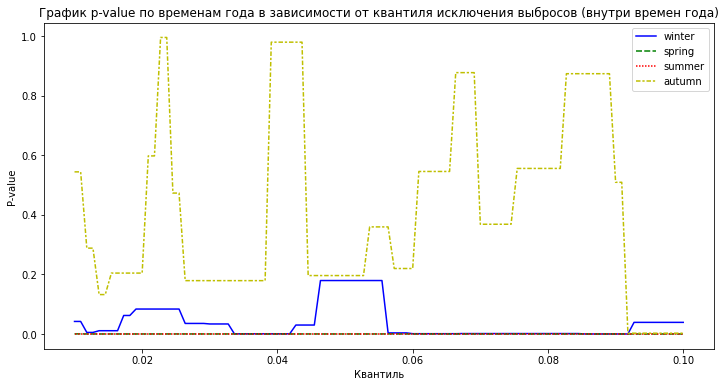

In [390]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=for_graph, palette={'summer':'r', 'spring':'g', 'winter':'b', 'autumn':'y'})
plt.title('График p-value по временам года в зависимости от квантиля исключения выбросов (внутри времен года)')
plt.xlabel('Квантиль')
plt.ylabel('P-value')
plt.show

Удаляя выбросы внутри времен года, очень сильно усиляем гипотезу для осени и значительно для зимы - для осени она может приниматься практически для любого уровня значимости. Интересно, что это совершенно нелинейный процесс - удалив слишком много значений, можно слишком сильно покромсать распределение и лишить его важных свойств. 

In [391]:
# теперь удаляем выбросы по всей выборке перед тестами времен года
quantiles = np.linspace(0.01, 0.1, num=100)
for_graph = {'winter':[], 'spring':[], 'summer':[], 'autumn': []}

for q in quantiles:
    for season in seasons:
        cond_spb1 = (df_spb['Дневная температура'] > df_spb['Дневная температура'].quantile(q))
        cond_spb2 = (df_spb['Дневная температура'] < df_spb['Дневная температура'].quantile(1-q))    
        cond_moscow1 = (df_moscow['Дневная температура'] > df_moscow['Дневная температура'].quantile(q))
        cond_moscow2 = (df_moscow['Дневная температура'] < df_moscow['Дневная температура'].quantile(1-q))
        
        a = df_spb.loc[cond_spb1 & cond_spb2]
        a = a.loc[a['Месяц'].isin(seasons[season]), 'Дневная температура'].to_numpy()
        b = df_spb.loc[cond_moscow1 & cond_moscow2]
        b = b.loc[b['Месяц'].isin(seasons[season]), 'Дневная температура'].to_numpy()

        diff = a.mean() - b.mean()
        var = ((a.std() ** 2) / len(a)) + ((b.std() ** 2) / len(b))
        z_obs = diff / (var ** (1/2))

        p_value = 2 * (1 - sts.norm(0, 1).cdf(abs(z_obs)))
        for_graph[season].append(p_value)
        
for_graph = pd.DataFrame(for_graph, index=quantiles)

<function matplotlib.pyplot.show(close=None, block=None)>

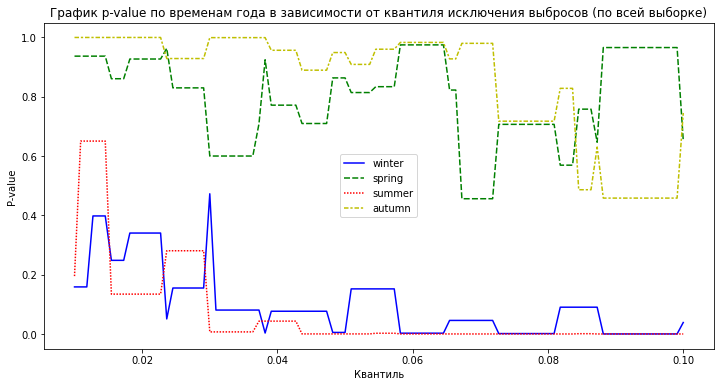

In [392]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=for_graph, palette={'summer':'r', 'spring':'g', 'winter':'b', 'autumn':'y'})
plt.title('График p-value по временам года в зависимости от квантиля исключения выбросов (по всей выборке)')
plt.xlabel('Квантиль')
plt.ylabel('P-value')
plt.show

На мой взгляд, очень необычные результаты. Z-тест с убранными по всей выборки выбросами гораздо сильнее Z-теста с выбросами, убранными внутри времен года. Осень в Москве и Петербурге все так же продолжает быть максимально похожей (для любого уровня значимости). Интересно, что с определенного порога отсечения p-value весны и осени двигаются симметрично - в отдельные периоды эти два времени года по температурам трудоноотличимы друг от друга. 

Чтобы сказать, какой из этих тестов адекватнее, стоит посмотреть на гистограммы отдельно времен года и всей выборки в целом. Полагаю, что адекватнее результаты по общей выборке - больше наблюдений и сильнее ЦПТ. Гистограммы по временам года в следующей ячейке, а по всей выборке - в следующем тесте. 

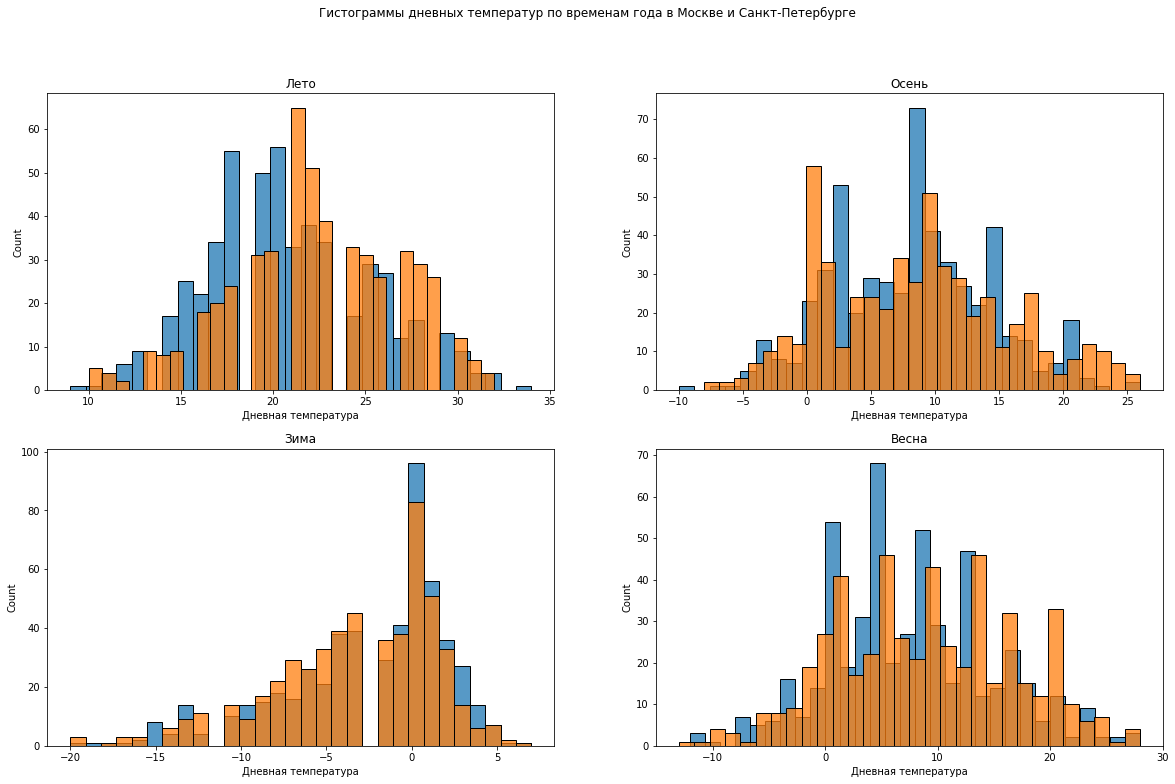

In [393]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12)) 
fig.suptitle('Гистограммы дневных температур по временам года в Москве и Санкт-Петербурге')

summer = sns.histplot(ax=axes[0][0], data=df_spb.loc[df_spb['Месяц'].isin(seasons['summer'])],
                     x="Дневная температура", bins=30)
sns.histplot(ax=axes[0][0], data=df_moscow.loc[df_moscow['Месяц'].isin(seasons['summer'])],
                     x="Дневная температура", bins=30)
summer.set(title='Лето')

autumn = sns.histplot(ax=axes[0][1], data=df_spb.loc[df_spb['Месяц'].isin(seasons['autumn'])],
                     x="Дневная температура", bins=30)
sns.histplot(ax=axes[0][1], data=df_moscow.loc[df_moscow['Месяц'].isin(seasons['autumn'])],
                     x="Дневная температура", bins=30)
autumn.set(title='Осень')

winter = sns.histplot(ax=axes[1][0], data=df_spb.loc[df_spb['Месяц'].isin(seasons['winter'])],
                     x="Дневная температура", bins=30)
sns.histplot(ax=axes[1][0], data=df_moscow.loc[df_moscow['Месяц'].isin(seasons['winter'])],
                     x="Дневная температура", bins=30)
winter.set(title='Зима')

spring = sns.histplot(ax=axes[1][1], data=df_spb.loc[df_spb['Месяц'].isin(seasons['spring'])],
                     x="Дневная температура", bins=30)
sns.histplot(ax=axes[1][1], data=df_moscow.loc[df_moscow['Месяц'].isin(seasons['spring'])],
                     x="Дневная температура", bins=30)
spring.set(title='Весна')

plt.show()

На самом деле не очень нормальные распределения, и адекватность тестов внутри времен года это уменьшает. Наилучшая картина у лета. 

### 2. Непараметрический тест. Критерий согласия Пирсона 

Здесь мы посмотрим на обещанную гистограмму температур по всей выборке и попробуем проверить гипотезу, одинаковое ли распределение температуры у Москвы и Санкт-Петербурга. 

In [66]:
from scipy.stats import chi2_contingency

In [144]:
# надо подготовить частотные таблицы, сделав так, чтобы в них не было столбцов, в каждом из которых были нули
crunch = pd.Series(np.zeros(len(np.arange(-20, 35))), index=np.arange(-20, 35)).rename('hi')

# сводная таблица частот по обоим городам
temp_pivot = pd.concat((crunch, 
                      df_spb['Дневная температура'].value_counts().sort_index().rename('spb'),
                     df_moscow['Дневная температура'].value_counts().sort_index().rename('moscow')),
                     axis=1).drop(columns=['hi']).fillna(0)

In [154]:
# убираем столбцы с теми измерениями, которых нет в выборке
temp_pivot.drop(temp_pivot.loc[(temp_pivot.spb == 0) & (temp_pivot.moscow == 0)].index[0], inplace=True)

In [172]:
# катастрофически низкий пвалуе, для любого уровня значимости гипотеза об одинаковом распределении отвергается
chi2_contingency(temp_pivot)[1]

9.843382815817522e-08

In [202]:
# чтобы тест работал качественно, рекомендуется избавиться от сравнительно малых частотных значений (10 единиц)
temp_pivot_forchi = temp_pivot.loc[(temp_pivot.spb > 10) & (temp_pivot.moscow > 10)].copy()
chi2_contingency(temp_pivot_forchi)[1]
# p-value в три раза больше, но все равно это ничтожно мало число

3.520981276209267e-08

Наконец строим обещанную гистограмму. По-хорошему, здесь два (или даже три) нормальных распределения. Видимо, когда я убирал хвосты по всей выборке перед Z-тестами времен года, я делал более "нормальными" эти распределения и рассматривал уже их внутри сезонов. 

В контексте теста согласия Пирсона отмечу на гистограмме минимальное пороговое значения частоты (черный пунктир), которое будем двигать и строить для него график. Радует то, что этот тест подходит для произвольных распределений. 

<function matplotlib.pyplot.show(close=None, block=None)>

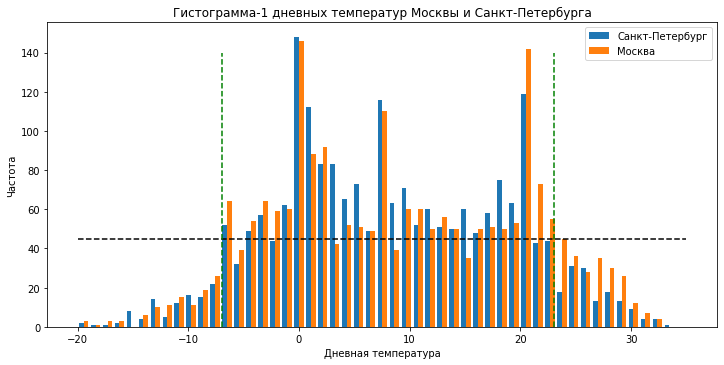

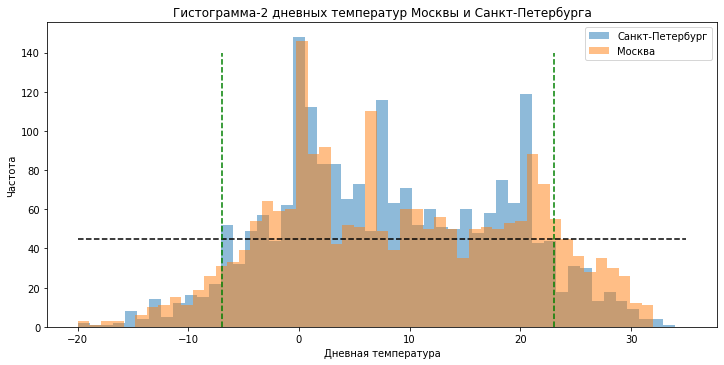

In [398]:
plt.figure(figsize=(15*0.8, 7*0.8))
plt.title('Гистограмма-1 дневных температур Москвы и Санкт-Петербурга')
plt.hist([df_spb['Дневная температура'], df_moscow['Дневная температура']], 
         alpha=1, bins=50, label=['Санкт-Петербург', 'Москва'])
plt.xlabel('Дневная температура')
plt.ylabel('Частота')
plt.hlines(45, -20, 35, color='k', linestyle='--')
plt.vlines(-7, 0, 140, color='g', linestyle='--')
plt.vlines(23, 0, 140, color='g', linestyle='--')
plt.legend()

plt.figure(figsize=(15*0.8, 7*0.8))
plt.title('Гистограмма-2 дневных температур Москвы и Санкт-Петербурга')
plt.hist(df_spb['Дневная температура'], bins=50, alpha=0.5, label='Санкт-Петербург')
plt.hist(df_moscow['Дневная температура'], bins=50, alpha=0.5, label='Москва')
plt.hlines(45, -20, 35, color='k', linestyle='--')
plt.vlines(-7, 0, 140, color='g', linestyle='--')
plt.vlines(23, 0, 140, color='g', linestyle='--')
plt.xlabel('Дневная температура')
plt.ylabel('Частота')
plt.legend()

plt.show

In [290]:
# посмотрим, как порог отсечения будет влиять на проверку гипотезы
numbers = np.arange(10, 46, 1)
pval = []

for number in numbers:
    temp_pivot_forchi = temp_pivot.loc[(temp_pivot.spb > number) & (temp_pivot.moscow > number)].copy()
    pval.append(chi2_contingency(temp_pivot_forchi)[1])

<function matplotlib.pyplot.show(close=None, block=None)>

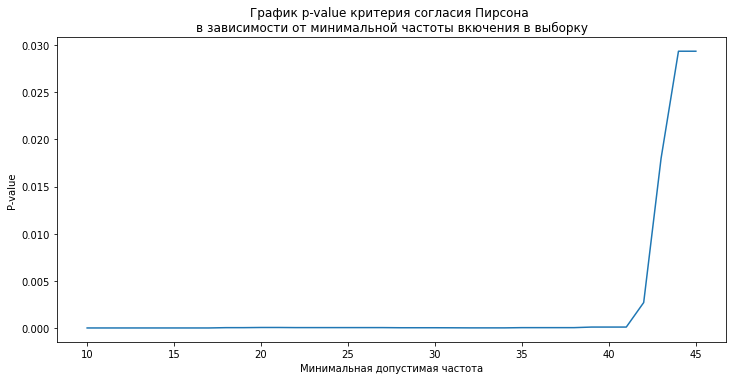

In [365]:
plt.figure(figsize=(15*0.8, 7*0.8))
plt.plot(numbers, pval)
plt.xlabel('Минимальная допустимая частота')
plt.ylabel('P-value')
plt.title('График p-value критерия согласия Пирсона \nв зависимости от минимальной частоты вкючения в выборку')
plt.show

Получилось дотянуть до допустимого уровня значимости в 1%, выкинув более четверти распределения. \
Гипотезу об одинаковом распределении стоит отвергнуть. \
Это согласуется с результатами z-теста - некоторые времена года похожи, а другие значимо различаются по своему температурному режиму. 

### 3. Параметрический тест. Гипотеза о равенстве дисперсий, тест Фишера

Сейчас будем смотреть на перепад температур и выяснять, насколько колеблется этот разброс для Москвы и Петербурга. 

Для теста Фишера необходимо проверить нормальность выборки. Она ловольно условная (см. гистограмму), но попробуем. Основная гипотеза - равенство дисперсий. 

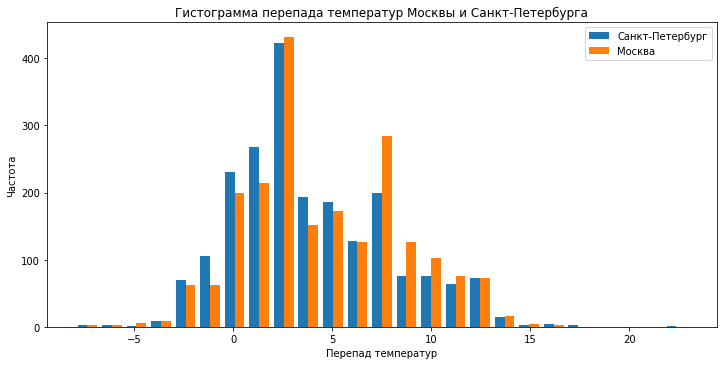

In [376]:
plt.figure(figsize=(15*0.8, 7*0.8))
plt.title('Гистограмма перепада температур Москвы и Санкт-Петербурга')
plt.hist([df_spb['Перепад температур'], df_moscow['Перепад температур']], 
         alpha=1, bins=25, label=['Санкт-Петербург', 'Москва'])
plt.xlabel('Перепад температур')
plt.ylabel('Частота')
plt.legend()

In [394]:
# проведем F-тест для разных уровней значимости

alphas = [0.01, 0.05, 0.1, 0.2]
for alpha in alphas: 
    f_left = sts.f(len(df_spb)-1, len(df_spb)-1).ppf(alpha/2)
    f_right = sts.f(len(df_spb)-1, len(df_spb)-1).pdf(1 - alpha/2)
    f_obs = df_spb['Перепад температур'].std() / df_moscow['Перепад температур'].std()
    if (f_obs > f_left) & (f_obs < f_right):
        print(f'При уровне значимости {alpha*100}% гипотеза о равенстве дисперсий принимается')
    else:
        print(f'При уровне значимости {alpha*100}% гипотеза о равенстве дисперсий отклоняется')

При уровне значимости 1.0% гипотеза о равенстве дисперсий принимается
При уровне значимости 5.0% гипотеза о равенстве дисперсий принимается
При уровне значимости 10.0% гипотеза о равенстве дисперсий принимается
При уровне значимости 20.0% гипотеза о равенстве дисперсий отклоняется


Гипотеза подтверждается для солидных уровней значимости. Можно говорить о том, что переменчивость погоды внутри суток для обеих столиц одинакова. 